# Notebook companion for UDA project Autumn 2024 

Jakob Creutzig, CID 02543387 

## User setup 

# Imports 

Please try to use the conda_enbvironment.yml file to create a conda environment with the necessary packages. It is quite 
helpful to use the exact same versions, in particular on pytorch and pytorch_geometric (pyg).  

This because the stored models can be loaded directly, if tyhe pytorch versions are compatible.  

I tried my very best to get pytorch_geometric to work with more modern python versions, but 3.10 was the best I could manage.  

In [96]:
from typing import Dict,  List, Callable
import os 
import json 
from requests import get 
import zipfile

import h5py
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import networkx as nx 
from torchmetrics import R2Score

import torch 
from torch import tensor
import torch.optim as optim
from torch.nn import MSELoss
from torch_geometric.nn import TAGConv
from torch_geometric.data import DataLoader
from torch_geometric.data import Data 


### Static setup 

These setup values should normally not require any changes, but if you want to store data different places, this is 
probably useful.  

In [97]:
# user specific setup 
# this should work fine as default but you might want to store data 
# other places so feel free to change the paths here

zip_folder = 'data_download_zip/' 
dl_data_folder = 'data/'

base_url = 'https://zenodo.org/record/8204334/files/'

ds20_url = base_url + 'ds20.zip'
ds100_url = base_url + 'ds100.zip'
texas_url = base_url + 'texas.zip'

ds20_zipfile = zip_folder + 'ds20.zip'
ds100_zipfile = zip_folder  + 'ds100.zip'
texas_zipfile = zip_folder + 'texas.zip'

ds20_data_folder = dl_data_folder + 'ds20/'
ds100_data_folder = dl_data_folder + 'ds100/'
texas_data_folder = dl_data_folder + 'texas/'

ds20_model_folder = 'models/ds20/'
ds100_model_folder = 'models/ds100/'
texas_model_folder = 'models/texas/'

EDGE_WGT = 9. 

our_rando_seed = 417417

### Dynamic user setup 

Here you steer the following notebook behaviour.  Re-running the hyper parameter tuning (make_iterative_models, make_griod_models) is computationally 
expensive and not strictly necessary, as we provide trained models for the given configurations.   

model_select can either select the best model from "iterative"/"grid" or load two models with given layers/max_channels/hops levels.  

In case you are not able to load models (due to version conflicts with pytorch) AND you do not want to run the hyper parameter selection, we also provide an option to train the selected model manually.  This only works with the manual option of model_select = [(nl1, nc1, nh1), (nl2, nc2, nh2)].  


In [98]:
#### 
#  Active user preferences 
# 
# Flags to activate/deactivate download, training, plotting etc 
#

download_data = True # True always downloads/extracts data, False only when data is missing 

# we made an iterative process for training models
# This can take quite some time, so you can instead also load pre-trained models.  
make_iterative_models = False   

# This runs simply through a grid of model hyperparameters and trains them all.
# Also quite time intensive, and I think outdated now because the iterative process 
# works reasonably well.  
make_grid_models = False 

# Which model to select for evaluation/plotting 
# You can get the best "iterative" or "grid" or a tuple (nl, nc, nh) for a specific model 

model_select = "iterative" 
# model_select = [(7,40,6), (7,40,6)] 

plot_results = True   # Plots the results of the training.
save_plots = True   # Saves the plots to disk.

# Training setup.  
NL = [4, 5, 6, 7] # number of layers to be trained 
NC = [20, 30, 40] # number of channels 
NH = [4, 5, 6, 7] # number of hops 

hp_idx = [
    (nl, nc, nh) 
    for nl in NL 
    for nc in NC  
    for nh in NH 
]


## Data load 

# Loading zip files from remote repository 

In [99]:
# loading data 
# This will take maybe 30 seconds initially.  
# Seecond time you should not notice the lag.  
def mkdir_if_not_exist(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

def make_path_if_not_exist(file):
    folder = os.path.dirname(file)
    mkdir_if_not_exist(folder)

def load_from_source(url, file, overwrite=False):
    make_path_if_not_exist(file)
    if not os.path.exists(file) or overwrite:
        with open(file, 'wb') as f:
            response = get(url)
            f.write(response.content)
            print(f"Downloaded {url} to {file}")
            f.close()

    else:
        print(f"File {file} already exists. Set overwrite=True to overwrite")

if download_data:
    load_from_source(ds20_url, ds20_zipfile)
    load_from_source(ds100_url, ds100_zipfile)
    load_from_source(texas_url, texas_zipfile)


File data_download_zip/ds20.zip already exists. Set overwrite=True to overwrite
File data_download_zip/ds100.zip already exists. Set overwrite=True to overwrite
File data_download_zip/texas.zip already exists. Set overwrite=True to overwrite


# Extracting zip file 

In [100]:
# now extract from zip files and load the data 
if download_data: 
    def extract_zip(zipfile_name, folder):
        zf = zipfile.ZipFile(zipfile_name)
        zf.extractall(folder)
        zf.close()

    extract_zip(ds20_zipfile, dl_data_folder)
    extract_zip(ds100_zipfile, dl_data_folder)
    extract_zip(texas_zipfile, dl_data_folder)


# Reading the train/validate/test data into variables 

In [101]:
# read in hd5 data 
def load_data(ds: str, data_folder:str, batch_size=500) -> DataLoader:  

    folder_name = data_folder # f"{data_folder}/{ds}/{type}/"

    file_name_input = f"{folder_name}/input_data.h5"
    file_name_snbs = f"{folder_name}/snbs.h5"

    snbs_data = h5py.File(file_name_snbs, 'r')
    input_data = h5py.File(file_name_input, 'r')['grids']

    grid_data = [
        Data(
            x = tensor(np.array(id_v['node_features']).reshape(-1, 1), dtype=torch.float),
            edge_index = tensor(np.array(id_v['edge_index']).T - 1, dtype=torch.long),
            edge_attr = tensor(np.full(shape=id_v['edge_index'].shape[0], fill_value=EDGE_WGT), dtype=torch.float),
            y = tensor(np.array(snbs_v), dtype=torch.float)
        )
        for id_v, snbs_v in zip(input_data.values(), snbs_data.values())
    ]

    return DataLoader(grid_data, batch_size=batch_size)

def load_dataset(ds:str, data_folder: str) -> Dict[str, DataLoader]: 
    res= dict() 
    res['train_ds'] = load_data(ds=ds, data_folder=f"{data_folder}/{ds}/train/")
    res['test_ds'] = load_data(ds=ds,  data_folder=f"{data_folder}/{ds}/test/")
    res['valid_ds'] = load_data(ds=ds, data_folder=f"{data_folder}/{ds}/valid/")
    return res 


data_ds20 = load_dataset('ds20', dl_data_folder)
data_ds100 = load_dataset('ds100', dl_data_folder)
data_texas = load_data('texas', data_folder=f"{dl_data_folder}/texas/")


c:\Users\nbjce1\Anaconda3\envs\uda_project_autumn_2024\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [128]:
# This is how the training data looks like

print(data_ds20['train_ds'].dataset[0])
print(data_ds100['train_ds'].dataset[0].x[:5].T) 
print(data_ds100['train_ds'].dataset[0].edge_index[:2,:5])
print(data_ds100['train_ds'].dataset[0].edge_attr[:5])
print(data_ds100['train_ds'].dataset[0].y[:5])

# check dimensions 

print(data_ds20['train_ds'].dataset[0])
print(data_ds100['train_ds'].dataset[0])
print(data_texas.dataset[0])

print(f"ds 20 has {len(data_ds20['train_ds'].dataset)} training samples.")
print(f"ds 20 has {len(data_ds20['valid_ds'].dataset)} validation samples.")
print(f"ds 20 has {len(data_ds20['test_ds'].dataset)} test samples.")

print(f"ds 100 has {len(data_ds100['train_ds'].dataset)} training samples.")
print(f"ds 100 has {len(data_ds100['valid_ds'].dataset)} validation samples.")
print(f"ds 100 has {len(data_ds100['test_ds'].dataset)} test samples.")


Data(x=[20, 1], edge_index=[2, 54], edge_attr=[54], y=[20])
tensor([[-1.,  1.,  1., -1., -1.]])
tensor([[0, 1, 0, 3, 0],
        [1, 0, 3, 0, 5]])
tensor([9., 9., 9., 9., 9.])
tensor([1.0000, 1.0000, 0.8447, 1.0000, 0.9946])
Data(x=[20, 1], edge_index=[2, 54], edge_attr=[54], y=[20])
Data(x=[100, 1], edge_index=[2, 292], edge_attr=[292], y=[100])
Data(x=[1910, 1], edge_index=[2, 5154], edge_attr=[5154], y=[1910])
ds 20 has 7000 training samples.
ds 20 has 1500 validation samples.
ds 20 has 1500 test samples.
ds 100 has 7000 training samples.
ds 100 has 1500 validation samples.
ds 100 has 1500 test samples.


## Definition of the model 

This code follows the code given in the github repo under https://github.com/PIK-ICoNe/dynamic_stability_datasets_gnn_paper-companion very closely, to the extent that some lines are identical.  The code is simpler since I removed the additional layer of model agnostic wrapper code.  I also found that the method used to train the models did not use the batch grouping correctly.   

We actually use the TAGModel in a standardized form.  We have three free parameters:  nlayers, nchannels, nhops.  The channels are set to be constant to nchannels, the number of hops 
per layer is set constantly to nhops.  We normalize in all layers, and we use the same activation function in all layers (ReLU).  This is wrapped in the convenience function make_tag_model.

In [103]:
class TAGConvModule(torch.nn.Module):
    def __init__(self, channels_in, channels_out, K_hops, activation, batch_norm) -> None:
        super().__init__()
        self.channels_in = channels_in
        self.channels_out = channels_out
        self.K_hops = K_hops
        self.activation = activation
        self.batch_norm = batch_norm

        self.conv = TAGConv(
            self.channels_in, 
            self.channels_out, 
            K=self.K_hops
        )
        if self.batch_norm:
            self.batch_norm_layer = torch.nn.BatchNorm1d(self.channels_out)

    def forward(self, data, x):
        # Add safety checks
        num_nodes = x.size(0)
        if data.edge_index.max() >= num_nodes:
            raise ValueError(f"Edge index contains invalid node indices. Max index: {data.edge_index.max()}, num nodes: {num_nodes}")
        
        if data.edge_index.min() < 0:
            raise ValueError(f"Edge index contains negative indices: {data.edge_index.min()}")
            
        # Apply convolution
        x = self.conv(x, data.edge_index, data.edge_attr)
        
        if self.batch_norm:
            x = self.batch_norm_layer(x)
        
        x = self.activation(x)
        return x
    
class TAGNet(torch.nn.Module):
    def __init__(
        self, 
        no_layers: int,
        channels: List[int],
        activation: List[Callable],
        K_hops: List[int],
        batch_norm: List[bool],
        final_linear_layer: bool,
        final_sigmoid_layer: bool = True, 
    ) -> None:
        super(TAGNet, self).__init__()

        self.no_layers = no_layers
        self.channels = channels
        self.activation = activation
        self.K_hops = K_hops
        self.batch_norm = batch_norm
        self.final_linear_layer = final_linear_layer
        self.final_sigmoid_layer = final_sigmoid_layer


        self.convlist = torch.nn.ModuleList([
            TAGConvModule(
                channels_in=self.channels[i],
                channels_out=self.channels[i+1],
                activation=self.activation[i],
                K_hops=self.K_hops[i],
                batch_norm=self.batch_norm[i]
            )
            for i in range(self.no_layers)
        ])

        if self.final_linear_layer:
            self.endLinear = torch.nn.Linear(self.channels[-1], 1)
        if self.final_sigmoid_layer: 
            self.endSigmoid = torch.nn.Sigmoid()

    def forward(self, data):
        x = data.x
        
        for conv in self.convlist:
            x = conv(data, x)
            
        if self.final_linear_layer:
            x = self.endLinear(x)
        if self.final_sigmoid_layer: 
            x = self.endSigmoid(x)
        
        return x.squeeze(-1)  # Match target shape


class TAGModule(torch.nn.Module): 
    def __init__(
        self, 
        channels, 
        activation,
        K_hops,
        batch_norm,
        final_linear_layer, 
        final_sigmoid_layer
    ) -> None:
        
        torch.manual_seed(our_rando_seed)
        torch.cuda.manual_seed(our_rando_seed)
        np.random.seed(our_rando_seed)        

        super(TAGModule, self).__init__()
        self.model = TAGNet(
            no_layers=len(channels) - 1,
            channels=channels,
            activation=activation,
            K_hops=K_hops,
            batch_norm=batch_norm,
            final_linear_layer=final_linear_layer,
            final_sigmoid_layer=final_sigmoid_layer
        )
        self.device = torch.device('cpu')
        self.model.to(self.device)
        self.criterion = MSELoss(reduction='mean')
        self.optimizer = optim.SGD(
            self.model.parameters(), lr=3, momentum=0.9
        ) 

        self.scheduler = optim.lr_scheduler.StepLR(
            self.optimizer, step_size=10, gamma=0.1
        )
    
    def forward(self, x): 
        return self.model(x)

    def r2score(self, predictions, labels):
        """
        Calculate R² score from predictions and labels
        Args:
            predictions: torch.Tensor of predicted values
            labels: torch.Tensor of true values
        Returns:
            R² score as a float
        """
        # Mean of true values
        y_mean = torch.mean(labels)
        
        # Total sum of squares
        ss_tot = torch.sum((labels - y_mean) ** 2)
        
        # Residual sum of squares
        ss_res = torch.sum((labels - predictions) ** 2)
        
        # R² calculation
        r2 = 1 - (ss_res / ss_tot)
        
        return r2.item()

    def train_epoch(self, data_loader, threshold=0.1):

        self.model.train()
        total_samples = 0
        correct = 0
        running_loss = 0

        y_true = []
        y_pred = []

        for batch in data_loader:
            batch = batch.to(self.device)
            self.optimizer.zero_grad()

            outputs = torch.squeeze(self.model.forward(batch))
            loss = self.criterion(outputs, batch.y)
            loss.backward()
            self.optimizer.step()

            # Update metrics

            correct += torch.sum((torch.abs(outputs-batch.y) < threshold)).item()
            total_samples += batch.y.size(0)
            running_loss += loss.item()

            y_true.append(batch.y.cpu().detach())
            y_pred.append(outputs.cpu().detach())


        accuracy = correct / total_samples

        y_true = torch.cat(y_true)
        y_pred = torch.cat(y_pred)
        r2_score = self.r2score(y_pred, y_true)

        return accuracy, r2_score

    def eval_model(self, data_loader, threshold=0.1): 
        self.model.eval() 
        correct = 0 
        all_labels = torch.Tensor(0).to(self.device)
        all_preds = torch.Tensor(0).to(self.device)

        with torch.no_grad(): 
            for _, (batch) in enumerate(data_loader):
                batch.to(self.device)
                outputs = torch.squeeze(self.model(batch))
                correct += torch.sum(( torch.abs(outputs-batch.y) < threshold ))
                all_labels = torch.cat([all_labels, batch.y])
                all_preds = torch.cat([all_preds, outputs])

        accuracy = correct / all_labels.shape[0]
        r2_score = self.r2score(all_preds, all_labels)

        return accuracy, r2_score
    
    def pred_v_actual(self, data_loader):
        """
        Extract predictions and ground truth from a data loader
        Args:
            data_loader: PyTorch Geometric DataLoader
        Returns:
            tuple (predictions, ground_truth) as numpy arrays
        """
        self.model.eval()
        all_labels = torch.Tensor(0).to(self.device)
        all_preds = torch.Tensor(0).to(self.device)

        with torch.no_grad():
            for _, (batch) in enumerate(data_loader):
                batch.to(self.device)
                outputs = torch.squeeze(self.model(batch))
                all_labels = torch.cat([all_labels, batch.y])
                all_preds = torch.cat([all_preds, outputs])

        # Convert to numpy arrays for easier handling
        return all_preds.cpu().numpy(), all_labels.cpu().numpy()       

# Update your model initialization
tag_net = TAGNet(
    no_layers=3,
    channels=[1, 32, 32, 1],  # Make sure dimensions match
    activation=[torch.nn.ReLU()] * 3,
    K_hops=[2] * 3,
    batch_norm=[True] * 3, 
    final_linear_layer=True
)

tag_module = TAGModule(
    channels=[1, 30, 30, 1],
    activation=[torch.nn.ReLU()] * 3,
    K_hops=[3] * 3,
    batch_norm=[True] * 3,
    final_linear_layer=False,
    final_sigmoid_layer=True
)
def triangle_channels(nl, nc):  
    # we want to interpolate in a geometric manner between 
    # 1 and nc, over nl.  

    log_int = np.linspace(0, 1, nl) 
    return [int(x) for x in np.ceil(nc**log_int)[1:]]


def make_tag_module(num_layers, num_channels, num_hops): 
    return TAGModule(
#        channels=[1] + triangle_channels(num_layers, num_channels)  + [1],
        channels = [1] + [num_channels]*(num_layers - 1) + [1],
        activation=[torch.nn.ReLU()] * num_layers,
        K_hops=[num_hops] * num_layers,
        batch_norm=[True] * num_layers,
        final_linear_layer=False,
        final_sigmoid_layer=True
    )


## Train model function 

The training loop is set up to capture train and validation loss and R2, and has a patience counter.  If a minimal gain over the previous best R2 validation score is not attained, the patience counter is increased; it is reset each time the minimal gain is realized.  This allows for early stopping.  

In [104]:
def train_model(tag_module, data_loader, epochs, patience_limit=50, min_perc_increase=0, print_at=None):
    best_so_far = -np.inf
    patience_used=0
    all_train_acc = [] 
    all_train_r2 = [] 
    all_test_acc = [] 
    all_test_r2 = [] 
    
    for epoch in range(epochs):
        train_acc, train_r2 = tag_module.train_epoch(data_loader['train_ds'], threshold=0.05)
        valid_acc, valid_r2 = tag_module.eval_model(data_loader['valid_ds'], threshold=0.05)
        if valid_r2 > best_so_far * (1 + min_perc_increase/100):
            best_so_far = valid_r2
            patience_used = 0
        else:
            patience_used += 1
            if patience_used > patience_limit :
                print(f"Early stopping at epoch {epoch}")
                break
        if print_at: 
            if epoch % print_at == 0:
                print(f"Epoch {epoch}: Train accuracy: {train_acc:.2f}, Train R2: {train_r2:.2f}, Valid accuracy: {valid_acc:.2f}, Valid R2: {valid_r2:.2f}")

        all_train_acc.append(float(train_acc))
        all_train_r2.append(float(train_r2))
        all_test_acc.append(float(valid_acc))
        all_test_r2.append(float(valid_r2))

    hist = {
        'train_acc': np.array(all_train_acc), 
        'train_r2': np.array(all_train_r2), 
        'valid_acc': np.array(all_test_acc), 
        'valid_r2': np.array(all_test_r2), 
    }
    return hist 



In [105]:
# Same thing, but for batches of models in turn, plus this saves both model and performance history in training.    

def train_batch(
        index_set, 
        which='ds20', 
        overwrite=False, 
        epochs=400, 
        patience_limit=400, 
        min_perc_increase = 0 
        ): 
    hist_dict = dict()
    model_dict = dict()
    
    training_folder = f'trained_models_{which}/'
    hist_folder = f'training_hist_{which}/'

    # make folders if not exist 
    mkdir_if_not_exist(training_folder)
    mkdir_if_not_exist(hist_folder)

    for idx in index_set: 
        training_file_name = training_folder + f'model_{str(idx)}.pth'
        if os.path.exists(training_file_name) and not overwrite:
            print(f"Model {str(idx)} already trained. Skipping")
            continue

        # find data set 
        if which == 'ds20': 
            data = data_ds20 
        elif which == 'ds100': 
            data = data_ds100
        else:
            raise ValueError('Unknown parameter which ' + which)

        print(f'Training {str(idx)}..')
        model_dict[idx] = make_tag_module(
            num_layers=idx[0], 
            num_channels=idx[1], 
            num_hops = idx[2]
            )
        hist_dict[idx] = train_model(
            model_dict[idx], 
            data, 
            epochs = epochs, 
            patience_limit=patience_limit, 
            print_at=50, 
            min_perc_increase = min_perc_increase
        )

        torch.save(model_dict[idx], training_folder + f'model_{str(idx)}.pth') 
        # transform hist dict into json and save too 
        tmp_dict = {
            k: list(v) 
            for k, v in hist_dict[idx].items() 
        }
        json.dump(
            tmp_dict, 
            open(f'{hist_folder}/{str(idx)}.pth', 'w') 
            )

    print("done.")


## Model selection / hyperparameter tuning

# Iterative ("gradient") model selection

This is a very simplistic idea, where we increase complexity of the model in each 'direction' (layers, channels, hops) and see if the model improves.  This is a very simple way to find a good model, but it is computationally expensive.  We have run this for you, and stored the results.

This method generally finds less powerful models than the grid search, but it is a bit faster.  

In [106]:
def iterative_hp_tuning(

    nl_init = 2, 
    nc_init = 10, 
    nh_init = 1, 

    inc_nl = 1, 
    inc_nc = 10,
    inc_nh = 1,

    max_depth = 20, 
    patience = 15,
    min_perc_increase=5, 
    overwrite = False, 
    which = 'ds20'
): 
    nl, nc, nh = (nl_init, nc_init, nh_init)
    chain_of_champions = [(nl, nc, nh)]

    hit_limit = False 

    def get_r2(idx, which='ds20'): 
        hist_folder = f'training_hist_{which}'
        perf = json.load(open(f'{hist_folder}/{str(idx)}.pth'))
        return perf['valid_r2'][-1]

    def train_and_get_r2(idx, which='ds20'): 
        train_batch([idx], which=which, epochs=400, patience_limit=patience, min_perc_increase = min_perc_increase, overwrite=overwrite) 
        return(get_r2(idx, which))

    def argmax_dict(my_dict): 
        """returns key with largest value.  Only works with comparable values.."""
        list_idx_max = np.argmax(list(my_dict.values()))
        return list(my_dict.keys())[list_idx_max]

    counter= 0 
    max_count = max_depth 

    while not hit_limit and counter < max_count: 
        curr_perf = {
            idx: train_and_get_r2(idx, which) 
            for idx in [
                (nl, nc, nh), 
                (nl + inc_nl, nc, nh), 
                (nl, nc + inc_nc, nh), 
                (nl, nc, nh + inc_nh), 
            ]
        }
        idx_with_max_perf = argmax_dict(curr_perf) 
        if idx_with_max_perf == (nl, nc, nh): 
            print(f"No further improvement registered.  Final performance {curr_perf[idx_with_max_perf]}.")
            hit_limit=True 
        else: 
            nl, nc, nh = idx_with_max_perf 
            chain_of_champions.append(idx_with_max_perf)
            print(f"=====  New champion: {idx_with_max_perf} =====")
            counter += 1

    return chain_of_champions 



In [107]:
def read_hist_data(idx, which: str='ds20'):
    hist_folder = f'training_hist_{which}'
    return json.load(open(f'{hist_folder}/{str(idx)}.pth'))

def load_tag_model(idx, which: str='ds20'): 
    training_folder = f'trained_models_{which}'
    return torch.load(f'{training_folder}/model_{str(idx)}.pth')

def all_indices(which: str='ds20'): 
    training_folder = f'trained_models_{which}'
    return [tuple(json.loads(
        '[' + f.replace('model_','').split('.')[0][1:-1] + ']'
        )) for f in os.listdir(training_folder)]

def all_indices_hist(which: str='ds20'): 
    training_folder = f'training_hist_{which}'
    return [tuple(json.loads(
        '[' + f.split('.')[0][1:-1] + ']'
        )) for f in os.listdir(training_folder)]


In [108]:
# We seem to be missing one model.  Let us ru nthis by hand 

for idx in chain_of_champions_100: 
    if idx not in all_indices('ds100'): 
        train_batch([idx], which='ds100', epochs=400, patience_limit=50, min_perc_increase=0)


In [109]:
# Iterative hyper parameter exploration 

if make_iterative_models: 
    chain_of_champions_20 = iterative_hp_tuning(
        which='ds20', 
        nl_init=3, nc_init = 10, nh_init=2, 
        min_perc_increase=0.5, patience = 10, 
        )
    chain_of_champions_100 = iterative_hp_tuning(
        which='ds100', 
        nl_init=3, nc_init = 10, nh_init=2, 
        min_perc_increase=0.5, patience = 10, 
        )
    # save the champions
    json.dump(chain_of_champions_20, open('champions_20.json', 'w'))
    json.dump(chain_of_champions_100, open('champions_100.json', 'w'))
else:
    chain_of_champions_20 = [tuple(x) for x in json.load(open('champions_20.json'))]
    chain_of_champions_100 = [tuple(x) for x in json.load(open('champions_100.json'))]

tm_best_it_20 = load_tag_model(chain_of_champions_20[-1], which='ds20')
tm_best_it_100 = load_tag_model(chain_of_champions_100[-1], which='ds100')

idx_best_it_20 = tuple(chain_of_champions_20[-1])
idx_best_it_100 = tuple(chain_of_champions_100[-1])



# Grid wise model selection

This is a very simnple setup.  We run through a grid of different options for layers, channels, and hops, and store the results.  This is *very*  computationally expensive (6 hours for the d20 model), but we have run this for you.

In [110]:
if make_grid_models:
    train_batch(
        which = 'ds20', 
        index_set=hp_idx,  
        min_perc_increase=0.1, 
        patience_limit=5, 
        epochs = 400, 
        overwrite=True 
        )

    train_batch(
        which = 'ds100', 
        index_set=hp_idx,  
        min_perc_increase=0.1, 
        patience_limit=5, 
        epochs = 400, 
        overwrite=True
        )
    
    # find best performing model in each 
    best_model_grid_20 = None
    best_model_grid_100 = None

    best_r2_20 = -np.inf
    best_r2_100 = -np.inf

    for idx in all_indices(which='ds20'):
        tm_20 = load_tag_model(idx, which='ds20')
        _, r2_20 = tm_20.eval_model(data_ds20['valid_ds'], threshold=0.05)

        if r2_20 > best_r2_20: 
            best_r2_20 = r2_20
            best_model_grid_20 = tm_20 
            best_idx_grid_20 = idx

    for idx in all_indices(which='ds100'):
        tm_100 = load_tag_model(idx, which='ds100')
        _, r2_100 = tm_100.eval_model(data_ds100['valid_ds'], threshold=0.05)

        if r2_100 > best_r2_100: 
            best_r2_100 = r2_100
            best_model_grid_100 = tm_100 
            best_idx_grid_100 = idx


In [111]:
# Find and plot all R2 validation results 

all_hist_d20 = {idx: read_hist_data(idx, which='ds20') for idx in all_indices_hist(which='ds20')}
all_hist_d100 = {idx: read_hist_data(idx, which='ds100') for idx in all_indices_hist(which='ds100')}

try: 
    all_models_d20 = {idx: load_tag_model(idx, which='ds20') for idx in all_indices(which='ds20')}  
    all_models_d100 = {idx: load_tag_model(idx, which='ds100') for idx in all_indices(which='ds100')}
    print("loaded all models successfully.")
    loaded_models = True 

except Exception as e: 
    print("Can't load models.  Check your pytorch/pytorch-geometric versions.")
    print("Will try to use stored derived values instead.")
    print(f"Caught exception: {e}")
    loaded_models = False



loaded all models successfully.


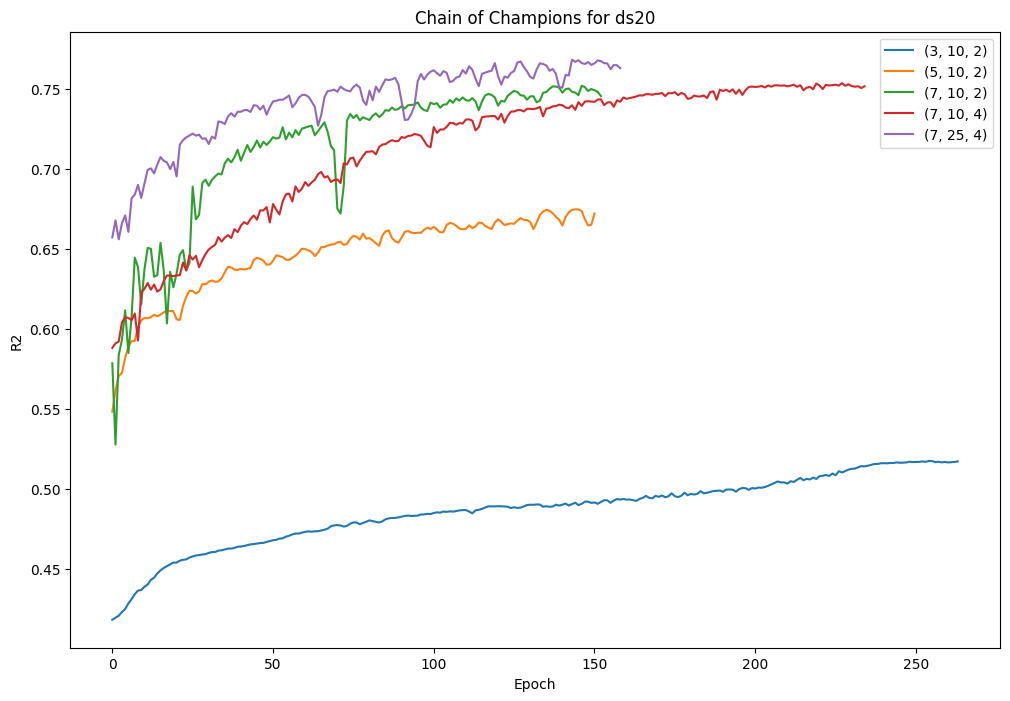

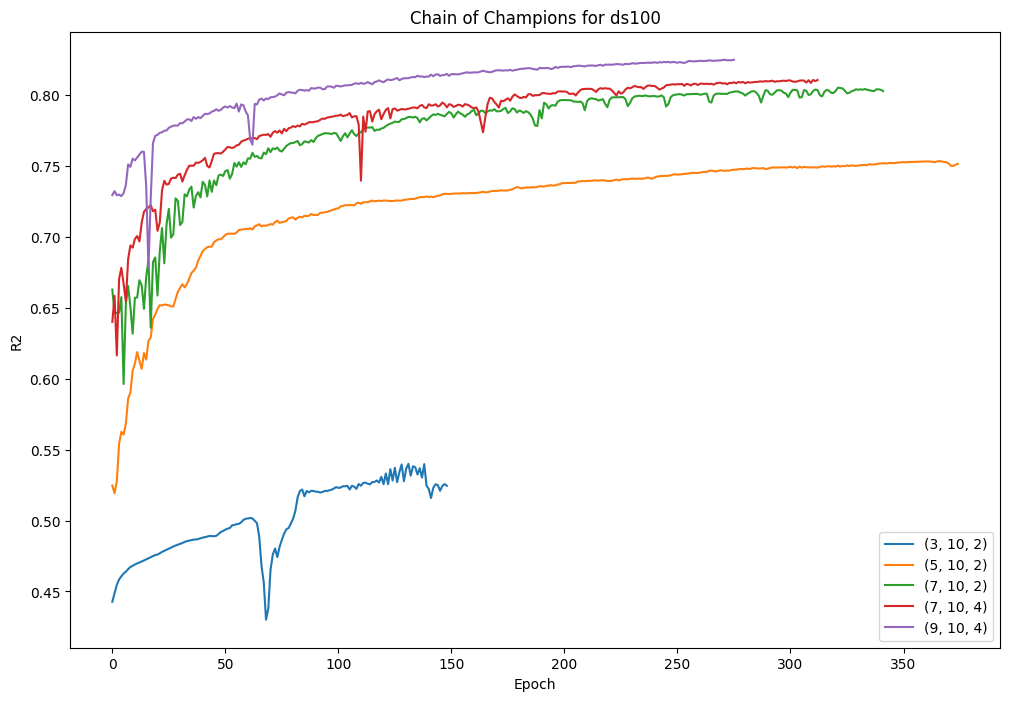

In [112]:
# show succession of champions 

def plot_champions(all_hist,chain_of_champions, which='ds20'): 
    plt.figure(figsize=(12, 8))
    for idx in chain_of_champions: 
        plt.plot(all_hist[idx]['valid_r2'][25:], label=f'{idx}')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('R2')
    plt.title(f'Chain of Champions for {which}')
    plt.show()

if plot_results:
    plot_champions(all_hist_d20, chain_of_champions_20, which='ds20')
    plot_champions(all_hist_d100, chain_of_champions_100, which='ds100')

In [113]:
# for all models, find no of parameters and performance on test set.
# This takes about 30 secods on a regular laptop.  

# This will not work if you can't load the models 

perf_par_d20 = [] 
perf_par_d100 = []

if loaded_models:

    for idx, model in all_models_d20.items():
        _, r2_test = model.eval_model(data_ds20['test_ds'], threshold=0.05)
        pars = sum(p.numel() for p in model.parameters())
        perf_par_d20.append({'idx': str(idx), 'r2': float(r2_test), 'pars': int(pars)})

    for idx, model in all_models_d100.items():
        _, r2_test = model.eval_model(data_ds100['test_ds'], threshold=0.05)
        pars = sum(p.numel() for p in model.parameters())
        perf_par_d100.append({'idx': str(idx), 'r2': float(r2_test), 'pars': int(pars)})

    df_perf_par_d20 = pd.DataFrame(perf_par_d20, columns=['idx', 'r2', 'pars'])
    df_perf_par_d100 = pd.DataFrame(perf_par_d100)

    df_perf_par_d20.to_json('df_perf_par_d20.json')
    df_perf_par_d100.to_json('df_perf_par_d100.json')
else:
    df_perf_par_d20 = pd.read_json('df_perf_par_d20.json')
    df_perf_par_d100 = pd.read_json('df_perf_par_d100.json')


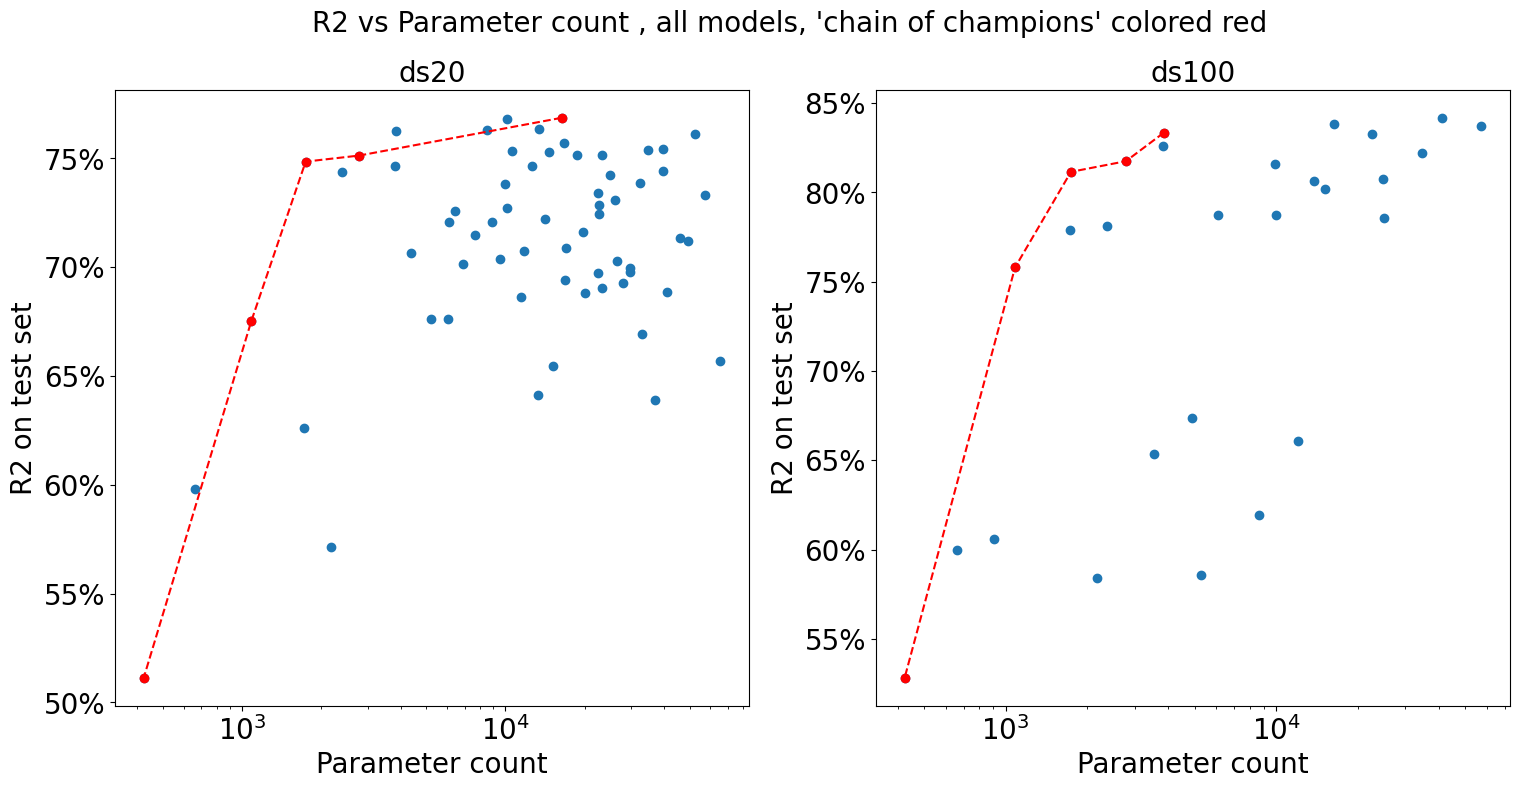

In [123]:
# Scatter plot to show parameter count v performance on test set.

def scatter_plot_dual(df1, df2, chain_of_champions1, chain_of_champions2, which1='ds20', which2='ds100'):
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    for df, chain_of_champions, ax, which in zip([df1, df2], [chain_of_champions1, chain_of_champions2], ax, [which1, which2]):
        ax.scatter(df['pars'], df['r2'])
        # subset of champions
        coc = df[df['idx'].isin([str(x) for x in chain_of_champions])]
        coc = coc.sort_values('r2', ascending=False)
        ax.plot(coc['pars'], coc['r2'],  'r--')
        ax.scatter(coc['pars'], coc['r2'], color='red')

        ax.set_xlabel('Parameter count')
        ax.set_xscale('log')
        ax.set_ylabel('R2 on test set')
        ax.set_title(f'{which}')
        ax.yaxis.set_major_formatter(PercentFormatter(1,decimals=0))
        # set font sizes to 12 
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(20)

    fig.suptitle("R2 vs Parameter count , all models, 'chain of champions' colored red", fontsize=20)
    
    if save_plots:
        plt.savefig('figures/chain_of_champions_perf.png')

    plt.show()

if plot_results:
    scatter_plot_dual(df_perf_par_d20, df_perf_par_d100, chain_of_champions_20, chain_of_champions_100, which1='ds20', which2='ds100')


## Loading of selected model 

Please see above under dynamic user settings for the different options.  We follow the options here and return two models, tm_best_20 and tm_best_100.  

In [115]:
# Model selection.  

if model_select == 'iterative':
    idx_best_20 = idx_best_it_20
    idx_best_100 = idx_best_it_100
    tm_best_20 = tm_best_it_20
    tm_best_100 = tm_best_it_100 
elif model_select == 'grid':
    idx_best_20 = best_idx_grid_20
    idx_best_100 = best_idx_grid_100
    tm_best_20 = load_tag_model(best_model_grid_20, which='ds20')
    tm_best_100 = load_tag_model(best_model_grid_100, which='ds100')
elif isinstance(model_select, list): 
    idx_best_20 = model_select[0]
    idx_best_100 = model_select[1]
    tm_best_20 = load_tag_model(idx_best_20, which='ds20')
    tm_best_100 = load_tag_model(idx_best_100, which='ds100')


In [116]:
# Calculate performance for best models.  

def r2perf(model, data):  
    _, r2_test = model.eval_model(data, threshold=0.05)
    return r2_test

perf_20train20eval = r2perf(tm_best_20, data_ds20['test_ds'])
perf_100train100eval = r2perf(tm_best_100, data_ds100['test_ds'])

print(f"Performance on ds20 ({idx_best_20}): {perf_20train20eval}")
print(f"Performance on ds100 ({idx_best_100}): {perf_100train100eval}")

perf_20train100eval = r2perf(tm_best_20, data_ds100['test_ds']) 
perf_100trainTexaseval = r2perf(tm_best_100, data_texas)

print(f"Performance on ds20, evaluated on ds100 ({idx_best_20}): {perf_20train100eval}")
print(f"Performance on ds100, evaluated on Texas ({idx_best_100}): {perf_100trainTexaseval}")



Performance on ds20 ((7, 25, 4)): 0.768656313419342
Performance on ds100 ((9, 10, 4)): 0.8334672451019287
Performance on ds20, evaluated on ds100 ((7, 25, 4)): 0.5642046928405762
Performance on ds100, evaluated on Texas ((9, 10, 4)): 0.7861849069595337


C:\Users\nbjce1\AppData\Local\Temp\ipykernel_19524\756045983.py:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


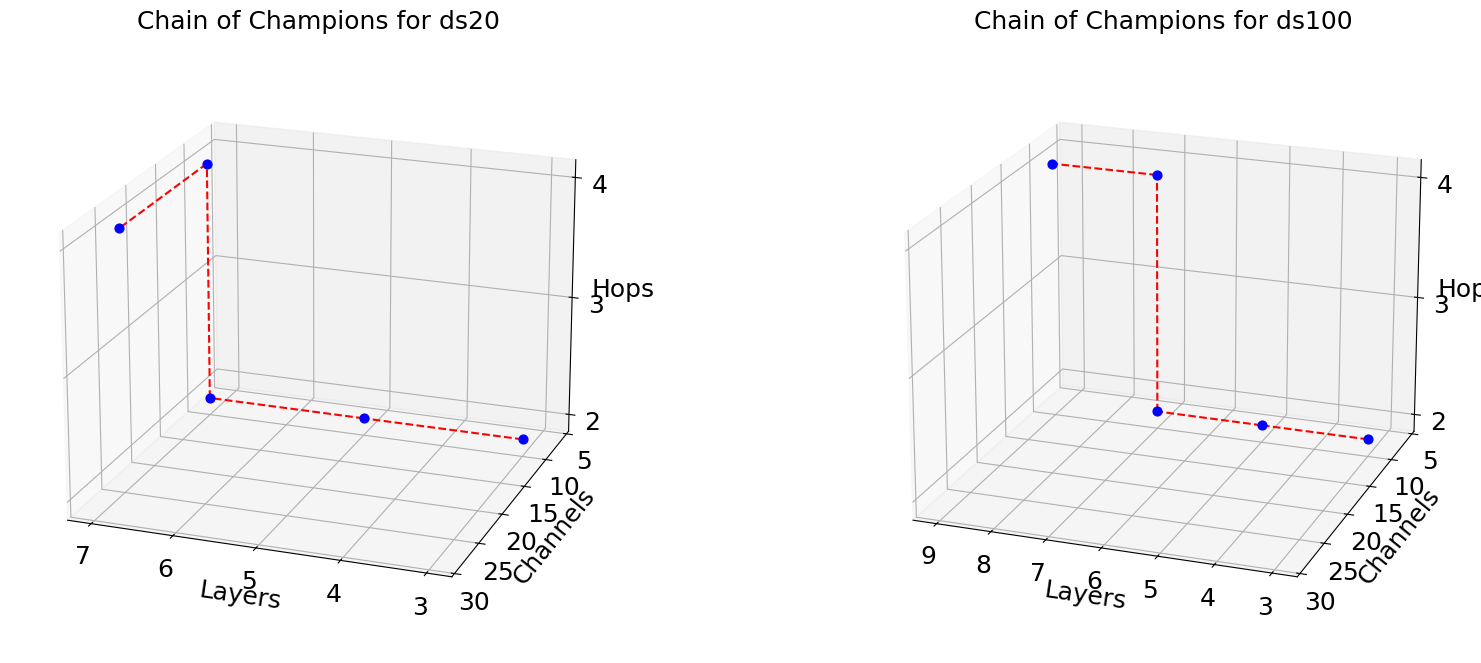

In [117]:
# we want now to make a 3d plot of the model indices in the "champions"  

ch_as_np_20 = np.array(chain_of_champions_20)
ch_as_np_100 = np.array(chain_of_champions_100)

# I am sure this can be done better.  
def plot_champions_3d(ch_as_np_20, ch_as_np_100):
    fig = plt.figure(figsize=(20, 8))
    
    ax1 = fig.add_subplot(121, projection='3d')
    for row in ch_as_np_20:
        ax1.scatter(row[0], row[1], row[2], label=f'{row}', color='blue', s=40)
    
    for i in range(1, len(ch_as_np_20)):
        row = ch_as_np_20[i]
        row_prev = ch_as_np_20[i-1]
        ax1.plot([row_prev[0], row[0]], [row_prev[1], row[1]], [row_prev[2], row[2]], 'r--')
    
    ax1.set_title('Chain of Champions for ds20')
    ax1.view_init(elev=20, azim=110)
    
    ax2 = fig.add_subplot(122, projection='3d')
    for row in ch_as_np_100:
        ax2.scatter(row[0], row[1], row[2], label=f'{row}', color='blue', s=40)
    
    for i in range(1, len(ch_as_np_100)):
        row = ch_as_np_100[i]
        row_prev = ch_as_np_100[i-1]
        ax2.plot([row_prev[0], row[0]], [row_prev[1], row[1]], [row_prev[2], row[2]], 'r--')
    
    ax2.set_title('Chain of Champions for ds100')
    ax2.view_init(elev=20, azim=110)

    # set fontsize on all tickmarks 

    for ax in [ax1, ax2]:
        ax.set_xlabel('Layers')
        ax.set_ylabel('Channels')
        ax.set_zlabel('Hops')
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.set_yticks([5, 10, 15, 20, 25, 30])
        ax.zaxis.set_major_locator(plt.MaxNLocator(integer=True))

        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.zaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()):
            item.set_fontsize(18)

    plt.tight_layout()
    if save_plots:
        plt.savefig('figures/chain_of_champions_idx.png')
    plt.show()

if plot_results:
    plot_champions_3d(ch_as_np_20, ch_as_np_100)

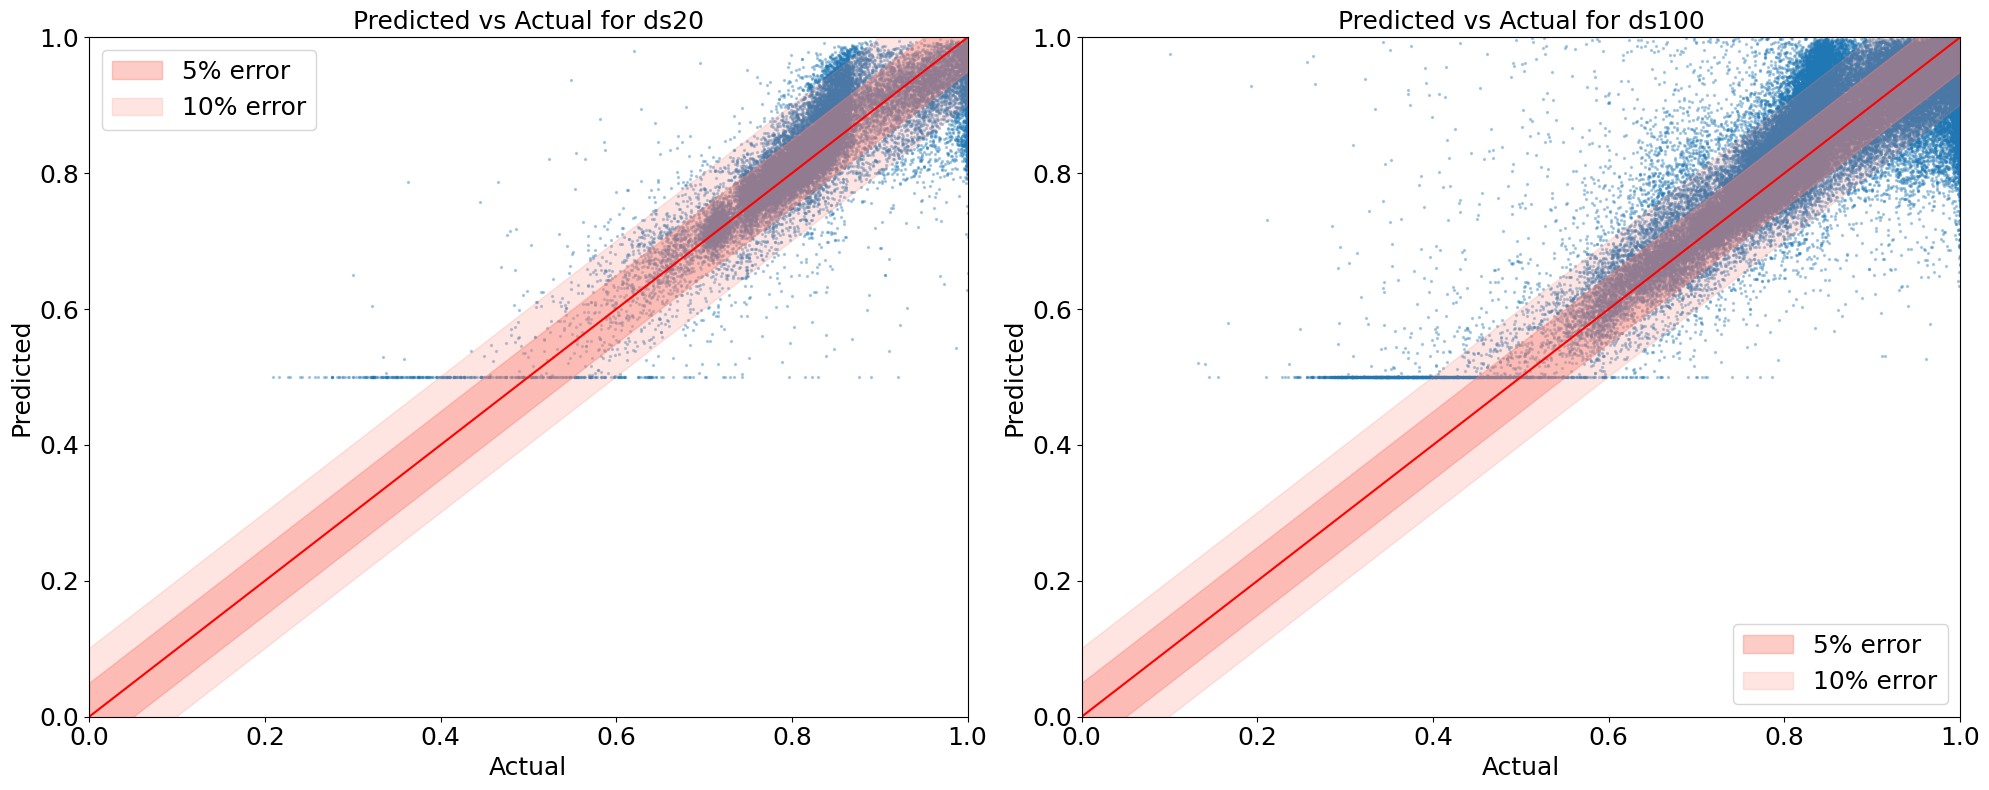

In [118]:
# plot predictions vs actuals for best models.

def plot_pred_v_actual(model_20, data_20, model_100, data_100):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # First subplot for ds20
    preds_20, actuals_20 = model_20.pred_v_actual(data_20)
    ax1.scatter(actuals_20, preds_20, alpha=0.3, s=2)
    ax1.set_title('Predicted vs Actual for ds20')
    
    # Second subplot for ds100
    preds_100, actuals_100 = model_100.pred_v_actual(data_100)
    ax2.scatter(actuals_100, preds_100, alpha=0.3, s=2)
    ax2.set_title('Predicted vs Actual for ds100')

    # common formatting 
    for ax in ax1, ax2:      
        ax.set_xlabel('Actual')
        ax.set_xlim([0, 1])
        ax.set_ylabel('Predicted')
        ax.set_ylim([0, 1])
        ax.plot([0, 1], [0, 1], 'r')

        ax.fill_between([0, 1], [0.05, 1.05], [-0.05, 0.95], color='salmon', alpha=0.4, label='5% error')
        ax.fill_between([0, 1], [0.1, 1.1], [-0.1, 0.9], color='salmon', alpha=0.2, label='10% error')
        ax.legend(fontsize=18)
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(18)
    
    plt.tight_layout()
    if save_plots:
        plt.savefig('figures/node_accuracy.png')
    plt.show()

if plot_results:
    plot_pred_v_actual(tm_best_20, data_ds20['test_ds'], 
                      tm_best_100, data_ds100['test_ds'])


In [122]:
# # illustration of in-/output 

# def plot_graph(
#         data, node_labels, ax=None, 
#         title=None, node_size=100, 
#         cmap='RdYlGn',
#         vmin=None, vmax=None,
#         add_colorbar=False,
#         colorbar_label=None):
    
#     edges = data.edge_index.numpy()
#     if ax is None:
#         fig, ax = plt.subplots()
    
#     ax.set_title(title)
#     ax.set_aspect('equal')

#     G = nx.Graph()
#     G.add_nodes_from(range(node_labels.shape[0]))
#     G.add_edges_from(edges.T)

#     pos = nx.kamada_kawai_layout(G)

#     nx.draw_networkx_nodes(
#         G, pos, ax=ax,
#         node_color='black',  # ring color
#         node_size=node_size  + min(max(40., 0.4*node_size), 20.),  # slightly larger size for the ring
#     )
#     # Draw the graph
#     nodes = nx.draw_networkx_nodes(
#         G, pos, ax=ax, node_color=node_labels, 
#         cmap=cmap, node_size=node_size,
#         vmin=vmin, vmax=vmax  # Add these parameters for consistent color scaling
#         )
#     edges = nx.draw_networkx_edges(G, pos, ax=ax)
    
#     if add_colorbar:
#         # Add colorbar with percentage formatting
#         cbar = plt.colorbar(nodes, ax=ax)
#         if colorbar_label:
#             cbar.set_label(colorbar_label)
#         cbar.ax.yaxis.set_major_formatter(
#             PercentFormatter(xmax=1.0, decimals=0)
#             )

# def plt_snbs(data, pred_snbs, node_size=100):

#     P = data.x.numpy()
#     snbs = data.y.numpy()

#     # Create the plot with equal sizes and shared colorbar
#     fig = plt.figure(figsize=(15, 5))
#     gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1.2])  # Slightly wider last subplot for colorbar

#     axs = [fig.add_subplot(gs[0, i]) for i in range(3)]

#     # Get the full range of values for consistent colormap
#     vmin = min(snbs.min(), pred_snbs.min())
#     vmax = max(snbs.max(), pred_snbs.max())


#     # Plot each graph

#     # first graph gets a purple/orange colormap 
#     plot_graph(
#         data, P, ax=axs[0], 
#         title='Grid, Source (purple) / Sink (red)', 
#         vmin=-1, vmax=1, cmap=mcolors.ListedColormap(['purple', 'orange']), 
#         node_size=node_size
#         )

#     plot_graph(data, snbs, ax=axs[1], title='True SNBS', vmin=vmin, vmax=vmax, 
#         node_size=node_size)
#     nodes = plot_graph(data, pred_snbs, ax=axs[2], title='Predicted SNBS', 
#                     vmin=vmin, vmax=vmax, add_colorbar=True, 
#                     colorbar_label='SNBS', 
#         node_size=node_size)

#     plt.tight_layout()

# data = data_ds100['train_ds'].dataset[0]
# pred_snbs = tag_module(data).detach().numpy()
# plt_snbs(data, pred_snbs, node_size=30)
# plt.savefig('figures/sample_graph_100.png')
# plt.show()

# data = data_ds20['train_ds'].dataset[0]
# pred_snbs = tag_module(data).detach().numpy()
# plt_snbs(data, pred_snbs, node_size=100)
# plt.savefig('figures/sample_graph_20.png')
# plt.show()


